# ER/NR Band Discrimination

In [1]:
!rm -Rf ~/.cache ./pax_*

import logging
logging.getLogger('rootpy.stl').setLevel(logging.CRITICAL)
logging.getLogger('hax').setLevel(logging.CRITICAL)
logging.getLogger('requests').setLevel(logging.CRITICAL)
logging.getLogger('ROOT').setLevel(logging.CRITICAL)
logging.basicConfig(level=logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set name of notebook for folder to save plots in
notebook_name = 'Xe1T_BandStuff'

# run imports
%run "../helpers/initialize_midway.ipynb"

# get all plotfunctions
%run "../helpers/plot_functions.ipynb"

Initialization done, Notebook was last run on: 19/08/2017


In [3]:
hax.misc.code_hider()

In [4]:
# Initialize pax/hax

pax_version = '6.6.5'

# pax configuration
from pax import units, configuration, datastructure
pax_config = configuration.load_configuration('XENON1T')
tpc_radius = pax_config['DEFAULT']['tpc_radius']
tpc_height = pax_config['DEFAULT']['tpc_length']

# hax configuration
import hax
from lax.lichen import Lichen, RangeLichen, ManyLichen, StringLichen
from lax import __version__ as lax_version

hax.init(minitree_paths = ['/home/danielfm/',
                         '/scratch/midway2/berget2/minitrees/',
                         '/scratch/midway2/breur/miniforest/',
                         '/project/lgrandi/xenon1t/minitrees/pax_v' + pax_version+'/',
                           '/project2/lgrandi/xenon1t/minitrees/pax_v' + pax_version+'/'],  
         pax_version_policy = pax_version)
#make_minitrees = False

In [5]:
# Parse Datasets
dsets = hax.runs.datasets

# select the latest versions
dsets = dsets[(dsets.pax_version == '6.6.5')]

# Select tags 
dsets = hax.runs.tags_selection(dsets, include=['sciencerun1'], exclude=['MVoff,blinded', 'NG,MVoff', 'Noise', 
       'blinded,MVoff', 'blinded,earthquake', 'blinded,flash',
       'blinded,messy,PMTtrip,MVoff,flash', 'blinded,messy,flash', 'messy',
       'messy,flash', 'messy,flash,pmttrip', 'messy,pmttrip,flash',
       'messy,pmttrip,flash,ramping', 'noise', 'test', 'trip,messy'])

# Select with a processed location
dsets = dsets[(dsets.location != '')]
print('We start with %i processed SR1 datasets' % len(dsets))

dsets_list = []
sources = ['Rn220','AmBe','neutron_generator']
for i, source in enumerate(sources):
    dsets_list.append(dsets[(dsets.source__type == source) ])
    print('%s Datasets: %i' % (source, len(dsets_list[i])) )

We start with 3142 processed SR1 datasets
Rn220 Datasets: 238
AmBe Datasets: 334
neutron_generator Datasets: 47


In [6]:
import lax
lax_version = lax.__version__
from lax.lichens import sciencerun1

dfs = []
for i, source in enumerate(sources):
    dfs.append(hax.minitrees.load(dsets_list[i].name, 
                                  treemakers=['Corrections','Basics','Extended','Fundamentals', 'TotalProperties', 'Proximity', 'TailCut'], 
                                  preselection = 'cs1<500', num_workers=20))

cs1<500 selection: 17147072 rows removed (3.10% passed)
cs1<500 selection: 10821022 rows removed (2.67% passed)
cs1<500 selection: 3822525 rows removed (3.73% passed)


In [7]:
# get low energy er/nr cuts
cut_list = [sciencerun1.LowEnergyRn220(), sciencerun1.LowEnergyAmBe(), sciencerun1.LowEnergyNG()]

In [8]:
excluded_cuts = ['CutS1LowEnergyRange']
for i in range(len(dfs)):
    print('%s Source Cut Summary:' % sources[i])
    dfs[i] = cut_list[i].process(dfs[i])
    for cut_name in cut_list[i].get_cut_names():
        if cut_name in excluded_cuts:
            continue
        else:
            dfs[i] = cuts.selection(dfs[i], dfs[i][cut_name], desc=cut_name)
    dfs[i] = cuts.below(dfs[i], 's1_range_50p_area', 400, desc='s1Width400')
    cuts.history(dfs[i])
    print('\n')
 

Rn220 Source Cut Summary:
CutFiducialCylinder1T selection: 502677 rows removed (8.52% passed)
CutS2Threshold selection: 17416 rows removed (62.79% passed)
CutS2AreaFractionTop selection: 1636 rows removed (94.43% passed)
CutS2SingleScatterSimple selection: 3220 rows removed (88.40% passed)
CutDAQVeto selection: 961 rows removed (96.08% passed)
CutS1SingleScatter selection: 318 rows removed (98.65% passed)
CutS1AreaFractionTop selection: 359 rows removed (98.46% passed)
CutS2PatternLikelihood selection: 10536 rows removed (53.97% passed)
CutS2Tails selection: 683 rows removed (94.47% passed)
CutInteractionPeaksBiggest selection: 234 rows removed (97.99% passed)
CutS1PatternLikelihood selection: 1161 rows removed (89.85% passed)
CutS2Width selection: 243 rows removed (97.64% passed)
CutS1MaxPMT selection: 185 rows removed (98.16% passed)
s1Width400 selection: 11 rows removed (99.89% passed)


AmBe Source Cut Summary:
CutAmBeFiducial selection: 255137 rows removed (14.00% passed)
CutS2Thr

In [9]:
#consts for CES
g2=11.463   # pe/e-
g1=0.1471 # pe/ph
w_value=0.0137

for i in range(len(dfs)):
    dfs[i]["CES"] = (dfs[i].cs2_bottom/g2 + dfs[i].cs1/g1)*w_value
    dfs[i]["DISC"] = np.log10(dfs[i].cs2_bottom/dfs[i].cs1)

### Recoil Bands, ER Discrimination, and Leakage

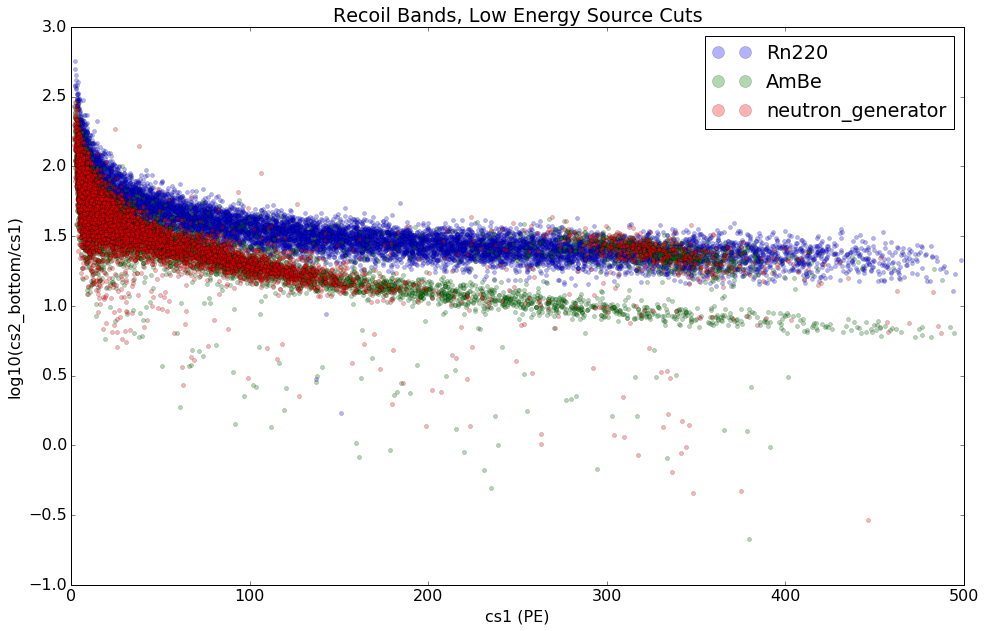

In [10]:

fig = plt.figure(figsize = (16,10))

for i in range(len(dfs)):
    plt.plot(dfs[i].cs1, np.log10(dfs[i].cs2_bottom/dfs[i].cs1),'o',label=sources[i],alpha=0.3,markersize=4)
    
plt.xlim(0,500)
plt.xlabel('cs1 (PE)')
plt.ylabel('log10(cs2_bottom/cs1)')
plt.title('Recoil Bands, Low Energy Source Cuts')
plt.legend(markerscale=3)

plt.show()

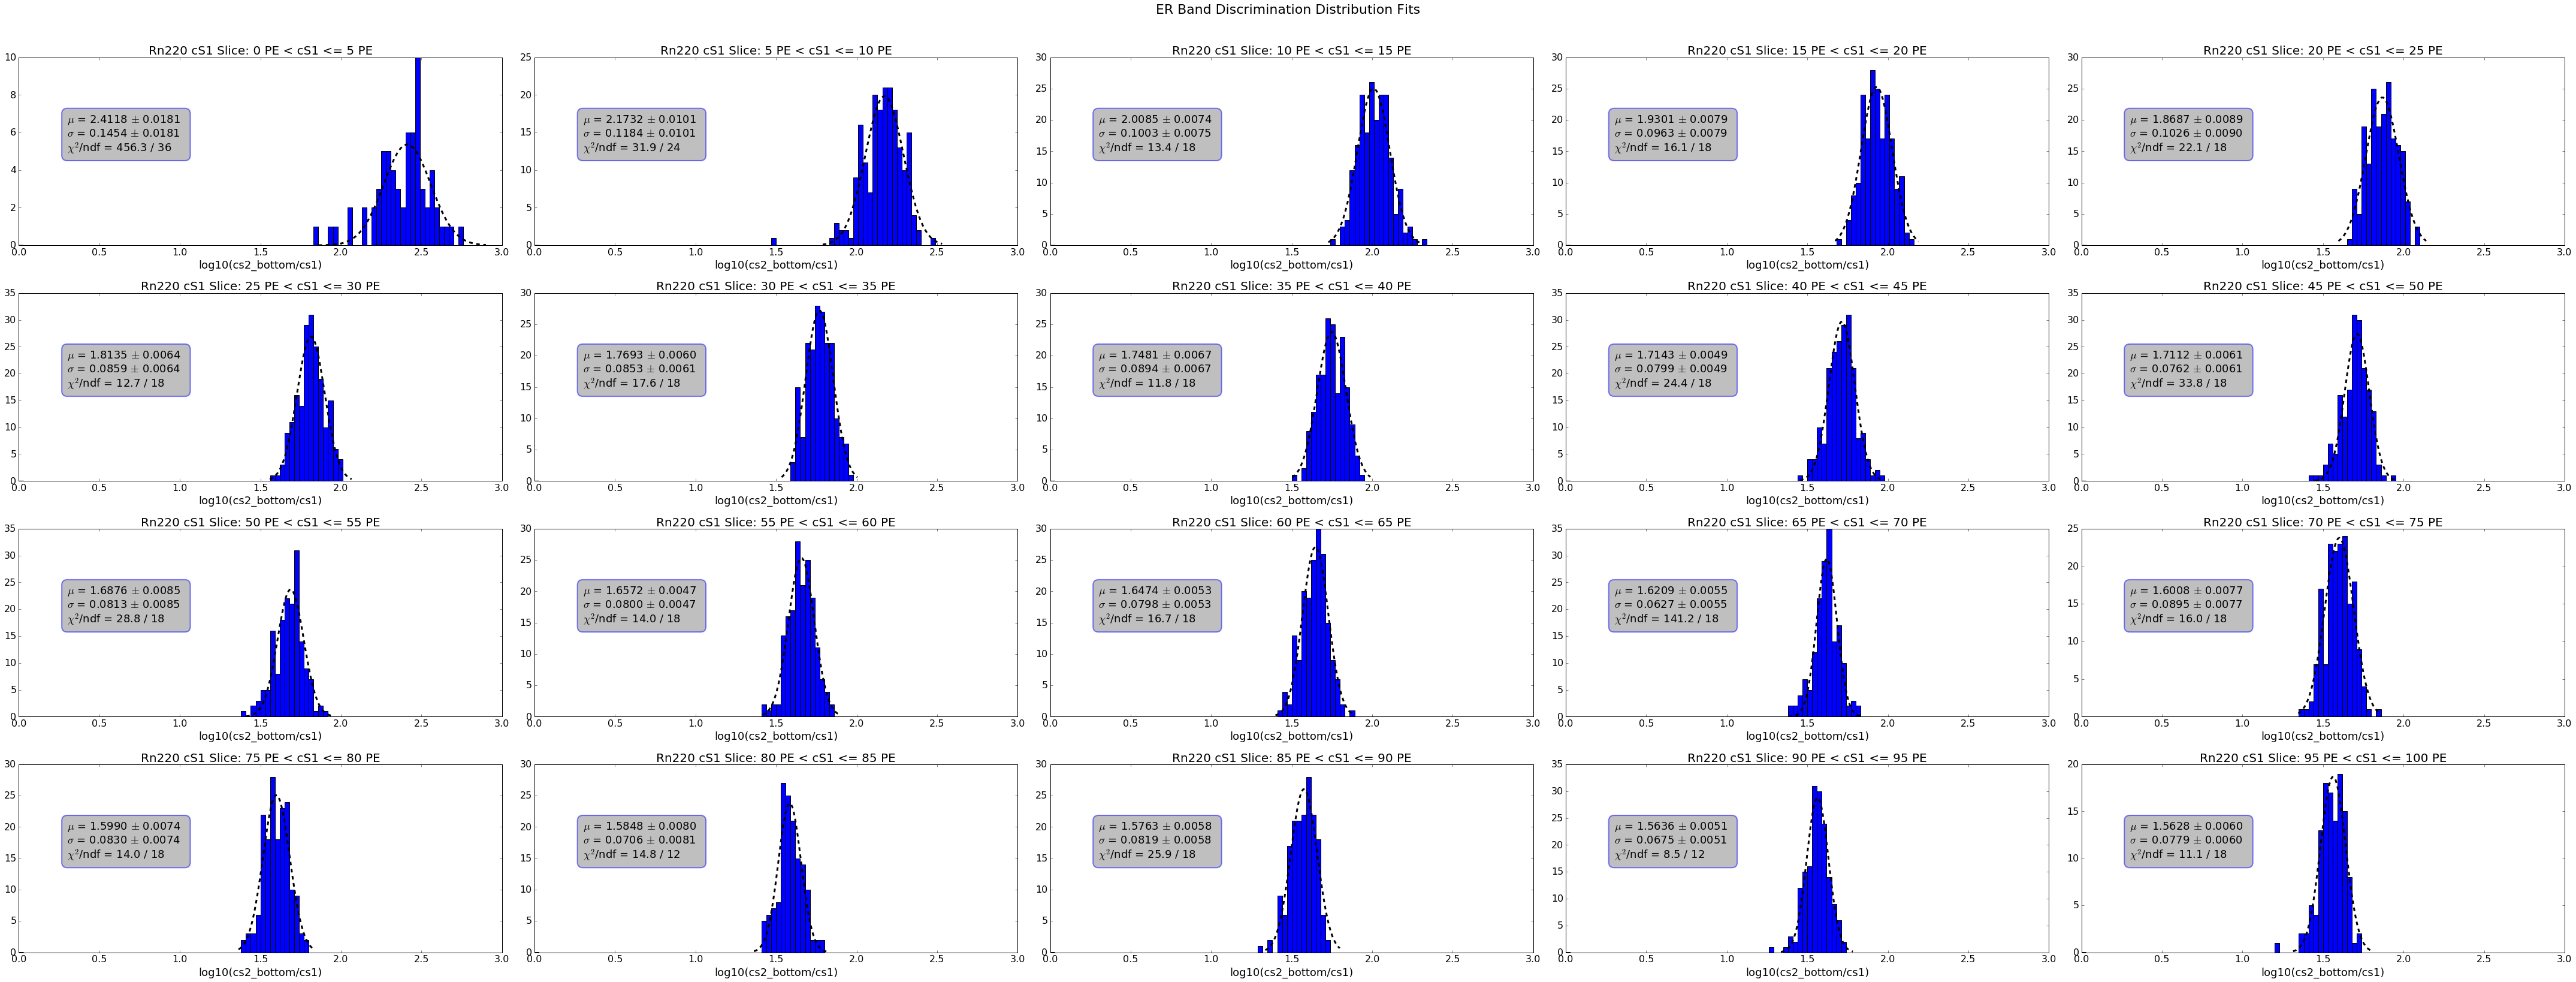

In [23]:
# Develop ER Discrimination Line

df_rn = dfs[0]

cs1_lim, cs1_width = 100, 5
cs1_bins = int(cs1_lim/cs1_width)
hist_range, hist_bins = [0,3], 100
hist_width = (hist_range[1]-hist_range[0])/hist_bins

fig = plt.figure(figsize = (12*5,6*4))
er_disc = []

for i in range(cs1_bins):
        
    # slice data in cs1
    cs1_min, cs1_max = i*cs1_width, (i+1)*cs1_width
    df = cuts.selection(df_rn, (df_rn['cs1'] > cs1_min) & (df_rn['cs1'] <= cs1_max), desc='cs1Slice', quiet=True)
    
    
    # fill and fit discrimination hist
    
    x = df.DISC
    mean = np.mean(x)
    i_mean = int((mean/hist_width)+0.5)
    std = np.std(x)
    i_std = int((std/hist_width)+0.5)
    i_min, i_max = max(i_mean-3*i_std,0), min(i_mean+3*i_std,hist_bins)
    
    plt.subplot(4,5,i+1)
    ax = plt.gca()
    
    n, bins, patches = plt.hist(x, bins=hist_bins, range=hist_range)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    x_fit = bin_centers[i_min:i_max]
    y_fit = n[i_min:i_max]
    guess = (mean, std, max(y_fit))
    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=guess)
    fit = gaussian(x_fit, *popt)
    perr = np.sqrt(np.diag(pcov))
    chi2, ndf = chisquare_ndf(y_fit,fit)
    
    s = ('$\mu$ = %.4f $\pm$ %.4f  \n$\sigma$ = %.4f $\pm$ %.4f \n$\chi ^2$/ndf = %.1f / %i' 
         % (popt[0], perr[0], popt[1], perr[1], chi2, ndf))
    bbox_props = dict(boxstyle="Round,pad=0.5", fc="gray", ec="blue", lw=2, alpha = 0.5)
    plt.text(0.1, 0.5, s,  transform=ax.transAxes, bbox=bbox_props, size=18)
    x_plot = np.linspace(mean-3*std,mean+3*std,50)
    y_plot = gaussian(x_plot, *popt)
    plt.plot(x_plot, y_plot, c='k', linewidth=3, linestyle='dashed')
    plt.xlabel('log10(cs2_bottom/cs1)', fontsize=18)
    plt.title('Rn220 cS1 Slice: %i PE < cS1 <= %i PE' % (cs1_min,cs1_max), fontsize=20)
        
    er_disc.append([np.mean([cs1_min,cs1_max]),popt[0],popt[1]])
    
er_disc = np.array(er_disc)

plt.suptitle('ER Band Discrimination Distribution Fits', fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
# Discrimination line
def disc_exp(cs1, p0, p1, p2, p3):
    return np.exp(p0+p1*cs1) + p2 + p3*cs1

# popt for SR0 99%
sr0_99_popt = (-0.645351,-0.0544212,1.52071,-0.00108844)

# Discrimination parameters for specific exclusion
def disc_popt(er_disc, sigmas):
    x = er_disc[:,0]
    y = er_disc[:,1] + sigmas*er_disc[:,2]
    
    # guess from SR0 99%
    guess = sr0_99_popt
    
    popt, pcov = curve_fit(disc_exp, x, y, p0=guess)
    return popt

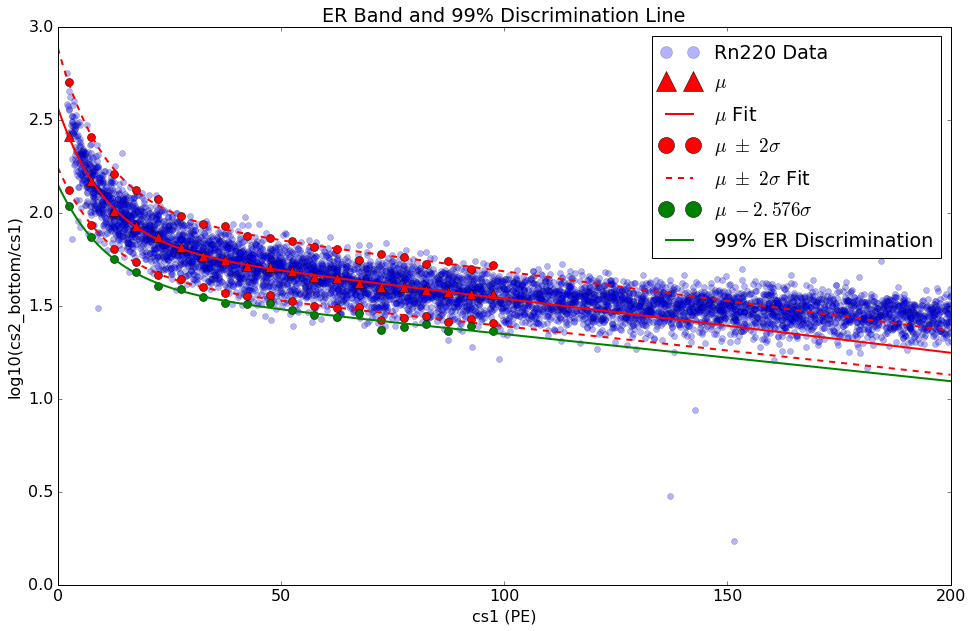

In [25]:
fig = plt.figure(figsize = (16,10))


plt.plot(df_rn.cs1, df_rn.DISC,'bo',label='Rn220 Data',alpha=0.3,markersize=6)


x = np.linspace(0,200,400)

plt.plot(er_disc[:,0], er_disc[:,1],'r^',label='$\mu$',markersize=10)
mean_popt = disc_popt(er_disc, 0)
mean_fit = disc_exp(x,*mean_popt)
plt.plot(x,mean_fit,'r-',lw=2,label='$\mu$ Fit')

plt.plot(er_disc[:,0], er_disc[:,1]+2*er_disc[:,2],'ro',label='$\mu\ \pm\ 2\sigma$',markersize=8)
p2s_popt = disc_popt(er_disc, 2)
p2s_fit = disc_exp(x,*p2s_popt)
plt.plot(x,p2s_fit,'r-',lw=2,linestyle='dashed',label='$\mu\ \pm\ 2\sigma$ Fit')

plt.plot(er_disc[:,0], er_disc[:,1]-2*er_disc[:,2],'ro',markersize=8)
n2s_popt = disc_popt(er_disc, -2)
n2s_fit = disc_exp(x,*n2s_popt)
plt.plot(x,n2s_fit,'r-',lw=2,linestyle='dashed')

plt.plot(er_disc[:,0], er_disc[:,1]-2.576*er_disc[:,2],'go',markersize=8,label='$\mu\ - 2.576\sigma$')
disc_99_popt = disc_popt(er_disc, -2.576)
disc_99_fit = disc_exp(x,*disc_99_popt)
plt.plot(x,disc_99_fit,'g-',lw=2,label='99% ER Discrimination')
    
plt.xlim(0,200)
plt.xlabel('cs1 (PE)')
plt.ylabel('log10(cs2_bottom/cs1)')
plt.title('ER Band and 99% Discrimination Line')
plt.legend(markerscale=2)

plt.show()

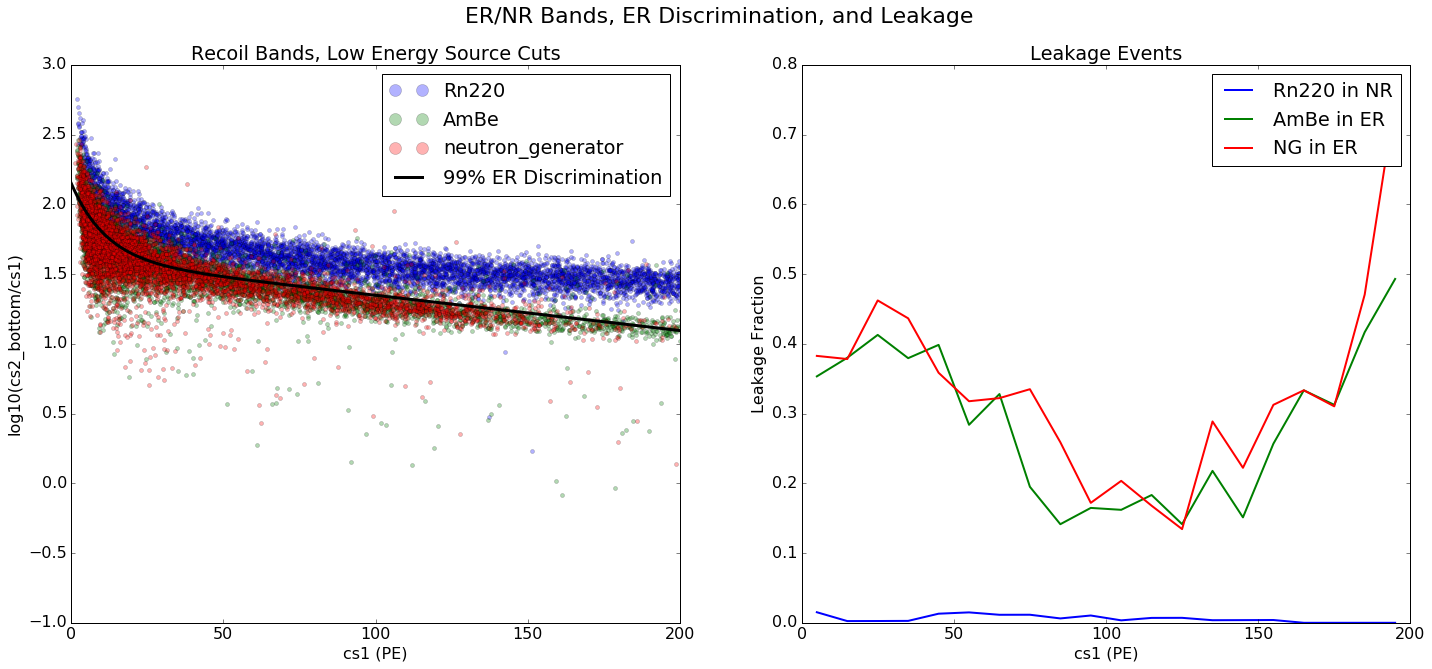

In [27]:
fig = plt.figure(figsize = (24,10))
plt.suptitle('ER/NR Bands, ER Discrimination, and Leakage', fontsize=22)

plt.subplot(121)
for i in range(len(dfs)):
    plt.plot(dfs[i].cs1, np.log10(dfs[i].cs2_bottom/dfs[i].cs1),'o',label=sources[i],alpha=0.3,markersize=4)
    
plt.plot(x,disc_99_fit,'k-',lw=3,label='99% ER Discrimination')
    
plt.xlim(0,200)
plt.xlabel('cs1 (PE)')
plt.ylabel('log10(cs2_bottom/cs1)')
plt.title('Recoil Bands, Low Energy Source Cuts')
plt.legend(markerscale=3)

plt.subplot(122)

# Calculate leakage ratios
cs1_lim, cs1_width = 200, 10
cs1_bins = int(cs1_lim/cs1_width)
leakage_ratios = []
for i in range(cs1_bins):
        
    # slice data in cs1
    cs1_min, cs1_max = i*cs1_width, (i+1)*cs1_width
    ratios = []
    for i in range(len(sources)):
        df_slice = cuts.selection(dfs[i], (dfs[i]['cs1'] > cs1_min) & (dfs[i]['cs1'] <= cs1_max), quiet=True)
        if i==0:
            df_slice_disc = cuts.selection(df_slice,df_slice['DISC'] < disc_exp(df_slice['cs1'],*disc_99_popt), quiet=True)
        else:
            df_slice_disc = cuts.selection(df_slice,df_slice['DISC'] > disc_exp(df_slice['cs1'],*disc_99_popt), quiet=True)
        ratios.append(len(df_slice_disc)/len(df_slice))
    leakage_ratios.append([np.mean([cs1_min,cs1_max]),ratios[0],ratios[1],ratios[2]])
leakage_ratios = np.array(leakage_ratios)

plt.plot(leakage_ratios[:,0],leakage_ratios[:,1],'-',lw=2,label='Rn220 in NR')
plt.plot(leakage_ratios[:,0],leakage_ratios[:,2],'-',lw=2,label='AmBe in ER')
plt.plot(leakage_ratios[:,0],leakage_ratios[:,3],'-',lw=2,label='NG in ER')

plt.xlabel('cs1 (PE)')
plt.ylabel('Leakage Fraction')
plt.legend(markerscale=3)
plt.title('Leakage Events')

plt.show()

### How Else Can We Discriminate ER/NR? ML!

In [28]:
# ML imports
from matplotlib.colors import ListedColormap
from pandas.tools.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [30]:
# prepare data
dfs_lowE = []
for i in range(len(dfs)):
    dfs_lowE.append(cuts.below(dfs[i],'cs1',200,quiet=True))
    if sources[i] == 'Rn220':
        dfs_lowE[i]['recoil'] = 'er'
    else:
        dfs_lowE[i]['recoil'] = 'nr'
        
df_ml = pd.concat(dfs_lowE)
df_ml_min = df_ml[['cs1','DISC','recoil']]

# Count recoil events
er_tot = len(df_ml_min[df_ml_min.recoil=='er'])
print('%i total ER events (Rn220)' % er_tot)
nr_tot = len(df_ml_min[df_ml_min.recoil=='nr'])
print('%i total NR events (AmBe and NG)' % nr_tot)

6030 total ER events (Rn220)
11282 total NR events (AmBe and NG)


In [31]:
# Split-out validation dataset
array = df_ml_min.values
X = array[:,0:len(df_ml_min.keys())-1]
Y = array[:,len(df_ml_min.keys())-1]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [32]:
# Spot Check Algorithms
scoring = 'accuracy'

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
print('ML Algorithm Accuracy Summary; Mean (Std) \n')
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ML Algorithm Accuracy Summary; Mean (Std) 

LR: 0.819336 (0.009987)
LDA: 0.815365 (0.010412)
KNN: 0.924038 (0.008033)
CART: 0.918189 (0.008241)
NB: 0.763302 (0.011559)
SVM: 0.925193 (0.009776)


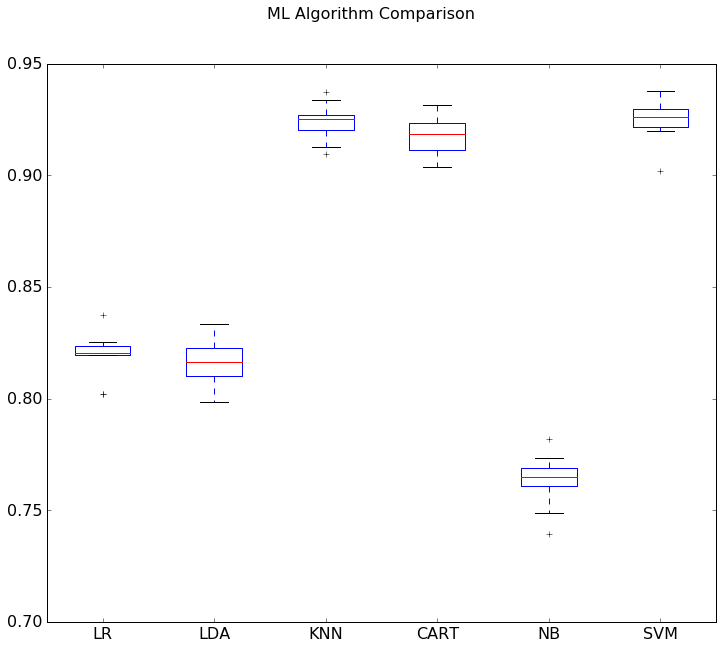

In [33]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('ML Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

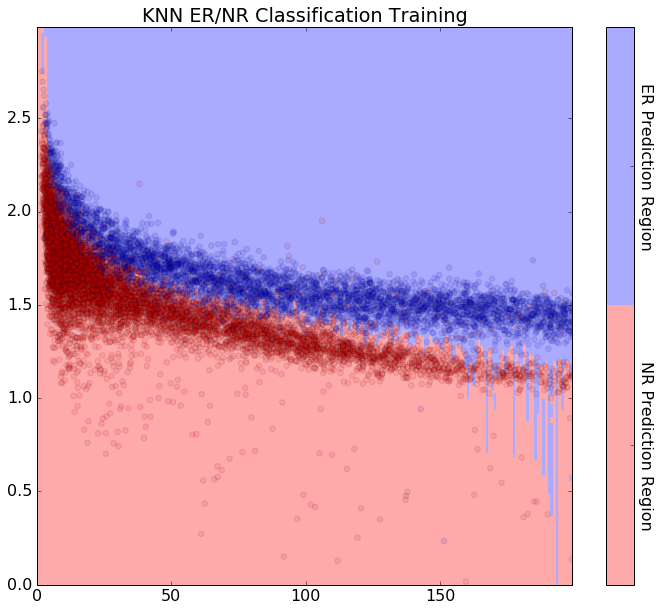

In [34]:
n_neighbors=15

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#0000FF', '#FF0000'])

knn = KNeighborsClassifier(n_neighbors, weights='distance')
knn.fit(X_train,Y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
xx, yy = np.meshgrid(np.arange(0, 200, 1),
                     np.arange(0, 3, 0.01))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
lookupTable, Z = np.unique(np.array(Z),return_inverse=True)
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
cbar = plt.colorbar()
cbar.set_ticks([0.25,0.75])
cbar.set_ticklabels(['ER Prediction Region','NR Prediction Region'])
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),rotation=-90)
cbar.ax.invert_yaxis()

# Plot also the training points
lookupTable, Y_colors = np.unique(np.array(Y_train),return_inverse=True)
ax.scatter(X_train[:, 0], X_train[:, 1], color=Y_colors, cmap=cmap_bold,
            edgecolor='k', s=30, alpha=0.1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("KNN ER/NR Classification Training")

plt.show()